# Week Three - Assignment Graph Visualization

Authors: Naomi Buell and Richie Rivera

## Instructions

*1. Load a graph database of your choosing from a text file or other source.  If you take a large network dataset from the web (such as from [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/)), please feel free at this point to load just a small subset of the nodes and edges.*

*2. Create basic analysis on the graph, including the graph’s diameter, and at least one other metric of your choosing. You may either code the functions by hand (to build your intuition and insight), or use functions in an existing package.*

*3. Use a visualization tool of your choice (Neo4j, Gephi, etc.) to display information.*

*4. Please record a short video (~ 5 minutes), and submit a link to the video in advance of our meet-up.*

## Intro

For this assignment, we use the [One Piece Interaction](https://github.com/jonaszeu/one-piece-interaction-data) dataset from jonaszeu on github. It was created by scraping a wiki of the show and documenting every interaction between two characters and categorizes it into an interaction type (Communication, Confrontation, Cooperation, etc). This dataset is available in a few different ways but we will be using the `.csv` that is created as our dat source.

## Step 1: Load Graph Database

First, we import libraries and load the dataset into a graph object.

In [44]:
# Import libraries
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In this dataset, each row corresponds to one interaction (edge) between two characters (nodes).

In [36]:
# Load the dataset directly from github
op_url = 'https://raw.githubusercontent.com/jonaszeu/one-piece-interaction-data/refs/heads/main/one_piece_interactions_1-1085.csv'
op_df = pd.read_csv(op_url)

# Make the Character Names "proper"
for e in ['Character 1', 'Character 2']: op_df[e] = op_df[e].str.title()

# Show a sample of the data
op_df.head()

,Episode,Character 1,Character 2,Interaction,Saga,Arc,Filler
0,1,Luffy,Sailors On A Cruise Ship,Perception,East Blue Saga,Romance Dawn,False
1,1,Luffy,Alvida Pirates,Confrontation,East Blue Saga,Romance Dawn,False
2,1,Luffy,Koby,Communication,East Blue Saga,Romance Dawn,False
3,1,Luffy,Koby,Cooperation,East Blue Saga,Romance Dawn,False
4,1,Koby,Alvida,Confrontation,East Blue Saga,Romance Dawn,False


In [37]:
# Get a total number of characters to get all the nodes
unique_characters = set(list(op_df['Character 1']) + list(op_df['Character 2']))

# Print information on the dataset
print(f"{op_df.shape[0]:,} Edges\n{len(unique_characters):,} Nodes")

28,185 Edges
1,448 Nodes


As there are over 28,000 and 1,400 nodes, we will filter the dataset to be only the `Romance Dawn` Arc and to omit Filler:

In [38]:
# Filtering the dataset
rd_df = op_df.loc[(op_df['Arc'] == 'Romance Dawn') & (~op_df['Filler'])]

# Get a total number of characters to get all the nodes
rd_unique_characters = set(list(rd_df['Character 1']) + list(rd_df['Character 2']))

# Print information on the dataset
print(f"{rd_df.shape[0]:,} Edges\n{len(rd_unique_characters):,} Nodes")

48 Edges
12 Nodes


With our filtered dataset, we can load it into a graph database. Thankfully, NetworkX already has methods to allow to easily load it from a pandas dataframe. With `nx.from_pandas_edgelist()`, we can also add the attributes of each connection which allows us to use it later on.

In [43]:
# Intializing the graph
rd_graph = nx.from_pandas_edgelist(
    rd_df,
    source = 'Character 1',
    target = 'Character 2',
    edge_attr = ['Episode', 'Interaction', 'Saga', 'Arc', 'Filler']
)

The native `nx.draw()` didn't work well as the default display configurations made it difficult to read. The below makes it more readable.

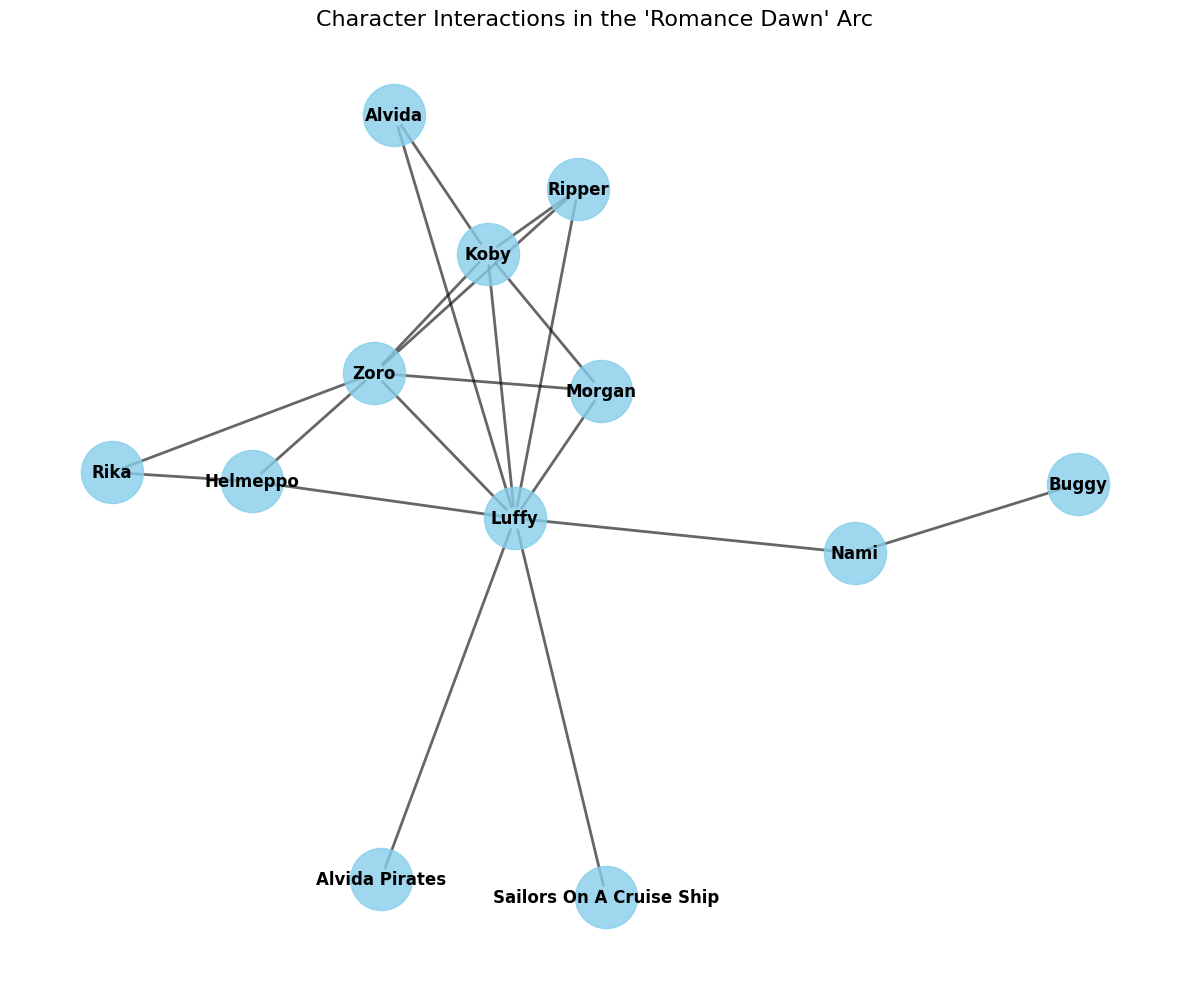

In [73]:
# Set up the figure size
plt.figure(figsize=(12, 10))

# Choose a layout for better node separation
pos = nx.spring_layout(rd_graph, k=0.7, iterations=50) 

# Draw the graph components with custom styling
nx.draw_networkx_nodes(rd_graph, pos, node_size=2000, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(rd_graph, pos, width=2, alpha=0.6, arrows=True, arrowsize=20)
nx.draw_networkx_labels(rd_graph, pos, font_size=12, font_family='sans-serif', font_weight='bold')

plt.title("Character Interactions in the 'Romance Dawn' Arc", size=16)
plt.axis('off')
plt.tight_layout()

# Save the plot as a PNG image before showing it
plt.savefig("rd_graph_plot.png")

plt.show()

## Step 2: Analysis

From the graph above, we can count and see that it has a diameter of 4 with the path being:

> Buggy - Nami - Luffy - Helmeppo - Rika

We can also use NetworkX to determine the diameter and the path using the below:

In [68]:
# Calculate all-pairs shortest paths
all_paths = dict(nx.all_pairs_shortest_path(rd_graph))

# Get the diameter of the graph
diameter = nx.diameter(rd_graph)
print(f"The diameter of the graph is: {diameter}\n")

# Find and print the paths that have the diameter length
found_paths = set()
for source, paths in all_paths.items():
    for target, path in paths.items():
        if len(path) - 1 == diameter:
            # Convert the path to a tuple
            current_path = tuple(path)
            # Check if the reversed path is not already in the set
            if tuple(reversed(current_path)) not in found_paths:
                found_paths.add(current_path)

if found_paths:
    print(f"The following path{'s have' if len(found_paths) > 1 else ' has'} a diameter of {diameter}:")

    for path in sorted(list(found_paths)):
        print('\t' + ' > '.join(list(path)))
else:
    print("No paths of that length found.")

The diameter of the graph is: 4

The following path has a diameter of 4:
	Rika > Zoro > Luffy > Nami > Buggy


# NAOMI AND RICHIE: WE NEED TO DO A SECOND AND MAYBE THIRD METRIC HERE

## Step 3: Visualization

Since we plotted it above during Step 1, we will display it again here:

![Romance Dawn Graph](rd_graph_plot.png "Romance Dawn Graph")

## Step 4: Video

Link to presentation video: [insert]

## References

[1] Robert West and Jure Leskovec: Human Wayfinding in Information Networks. 21st International World Wide Web Conference (WWW), 2012.

[2] Robert West, Joelle Pineau, and Doina Precup: Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts. 21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.